<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P7%20-%20D%C3%A9veloppez%20une%20preuve%20de%20concept/D%C3%A9veloppez_une_preuve_de_concept_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Je vais essayer ici d'utiliser un modèle ViT pré-entrainé par Google, mis à disposition sur le site HuggingFace : https://huggingface.co/google/vit-base-patch16-224-in21k

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 10.0 MB/s 
     |████████████████████████████████| 61 kB 638 kB/s 
     |████████████████████████████████| 895 kB 66.0 MB/s 
     |████████████████████████████████| 3.3 MB 53.5 MB/s 


In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
from PIL import Image
import requests
from google.colab import drive
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,\
    RandomContrast, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanAbsoluteError, \
  MeanAbsolutePercentageError
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 7.7 MB/s 


In [3]:
google_vit_model = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(google_vit_model)
model = ViTForImageClassification.from_pretrained(google_vit_model)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

(-0.5, 639.5, 479.5, -0.5)

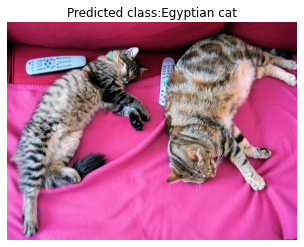

In [4]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

def predict(image):
  """
  model predicts one of the 1000 ImageNet classes
  """
  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  return model.config.id2label[predicted_class_idx]

plt.title("Predicted class:" + predict(image))
plt.imshow(image)
plt.axis("off")

ça fonctionne ! je vais tester les prédictions avec des images de mon jeu de données "Stanford Dogs dataset"

In [5]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/gdrive
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


In [6]:
dataset_dir = "./images/"

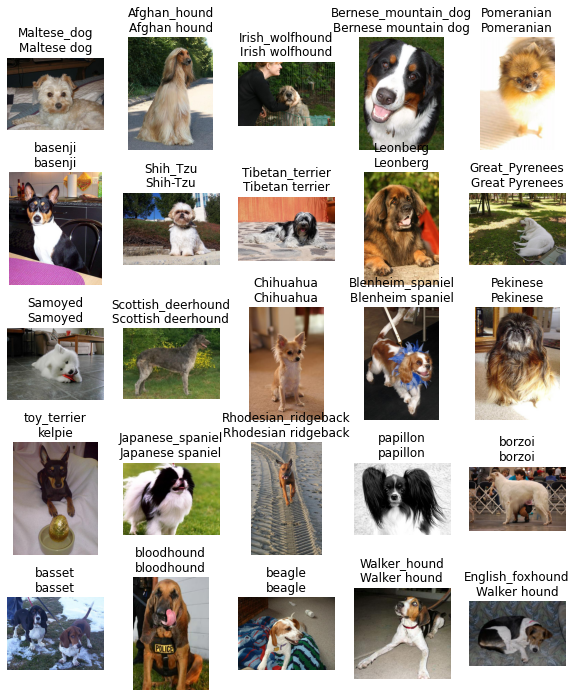

In [8]:
plt.figure(figsize=(10, 12))
i = 1
for sub_dir in os.listdir(dataset_dir):
    sub_dir_images = os.listdir(dataset_dir + sub_dir)
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 25 and j == 0:
            img_path = os.path.join(dataset_dir, sub_dir, sub_dir_image)
            img = Image.open(img_path)
            plt.subplot(5, 5, i)
            plt.axis('off')
            race = sub_dir.split('-')[1]
            plt.title(race + '\n' + predict(img).split(',')[0])
            plt.imshow(img)
            i = i + 1
            j = j + 1
plt.show()

Ok... Le modèle a presque tout bon : c'est un peu trop parfait ! Il n'y a pas forcément d'intérêt à faire du Transfer Learning pour ce dataset, mais je vais tenter l'exercice tout de même !

Je garde en note dans les 3 cellules ci-dessous une méthode qui pourrait fonctionner, mais qui demande trop de RAM par rapport à ce dont je dispose actuellement sur Colab (12,7Go)

In [7]:
try:
    import hugsvision
except:
    !pip install -q hugsvision
    import hugsvision
    
print(hugsvision.__version__)

     |████████████████████████████████| 376 kB 13.3 MB/s 
     |████████████████████████████████| 525 kB 64.9 MB/s 
     |████████████████████████████████| 332 kB 82.9 MB/s 
     |████████████████████████████████| 829 kB 71.5 MB/s 
     |████████████████████████████████| 132 kB 80.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 271 kB 69.3 MB/s 
     |████████████████████████████████| 192 kB 79.5 MB/s 
     |████████████████████████████████| 160 kB 88.1 MB/s 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


0.75


In [8]:
from hugsvision.dataio.VisionDataset import VisionDataset

train, test, id2label, label2id = VisionDataset.fromImageFolder(
	dataset_dir,
	test_ratio   = 0.2,
	balanced     = True,
	augmentation = True
)

Split Datasets...
Balance train dataset...
The less represented label in train as 148 occurrences
Size of train after balancing is 17760
train_ds:  14208
+---------+---------------------+----------------------------+-----------------------+--------------------+--------------------+----------------------------+--------------------+-----------------------+-------------------------------+------------------------+------------------+------------------+----------------------+--------------------+-----------------------------------+------------------------+----------------------------+-------------------+------------------+---------------------------+-----------------------------+-------------------+------------------------+------------------------------+----------------------+------------------+------------------------------+----------------------+-------------------------------------+------------------------------------------+------------------------------+--------------------------+-------

In [10]:
len(label2id)

120

In [11]:
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
google_vit_model = 'google/vit-base-patch16-224-in21k'
trainer = VisionClassifierTrainer(
    model_name   = "MyDogsBreedsModel",
    train      	 = train,
    test      	 = test,
    output_dir   = "./out/",
    max_epochs   = 1,
    batch_size   = 32,
    lr 		       = 2e-5,
    fp16	     = True,
    model = ViTForImageClassification.from_pretrained(
        google_vit_model,
        num_labels = len(label2id),
        label2id   = label2id,
        id2label   = id2label
    ),
    feature_extractor = ViTFeatureExtractor.from_pretrained(
        google_vit_model,
    ),
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

{'0': 'n02085620-Chihuahua', '1': 'n02085782-Japanese_spaniel', '2': 'n02085936-Maltese_dog', '3': 'n02086079-Pekinese', '4': 'n02086240-Shih_Tzu', '5': 'n02086646-Blenheim_spaniel', '6': 'n02086910-papillon', '7': 'n02087046-toy_terrier', '8': 'n02087394-Rhodesian_ridgeback', '9': 'n02088094-Afghan_hound', '10': 'n02088238-basset', '11': 'n02088364-beagle', '12': 'n02088466-bloodhound', '13': 'n02088632-bluetick', '14': 'n02089078-black-and-tan_coonhound', '15': 'n02089867-Walker_hound', '16': 'n02089973-English_foxhound', '17': 'n02090379-redbone', '18': 'n02090622-borzoi', '19': 'n02090721-Irish_wolfhound', '20': 'n02091032-Italian_greyhound', '21': 'n02091134-whippet', '22': 'n02091244-Ibizan_hound', '23': 'n02091467-Norwegian_elkhound', '24': 'n02091635-otterhound', '25': 'n02091831-Saluki', '26': 'n02092002-Scottish_deerhound', '27': 'n02092339-Weimaraner', '28': 'n02093256-Staffordshire_bullterrier', '29': 'n02093428-American_Staffordshire_terrier', '30': 'n02093647-Bedlington_t

Using amp half precision backend
***** Running training *****
  Num examples = 14208
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 444


Trainer builded!
Start Training!


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Epoch,Training Loss,Validation Loss
1,No log,4.331300


***** Running Evaluation *****
  Num examples = 3552
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/trainer/
Configuration saved in ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/trainer/config.json
Model weights saved in ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/trainer/pytorch_model.bin
Configuration saved in ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/model/config.json
Model weights saved in ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/model/pytorch_model.bin
Configuration saved in ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/feature_extractor/preprocessor_config.json


Model saved at: ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39


In [12]:
hyp, ref = trainer.evaluate_f1_score()

100%|██████████| 3552/3552 [01:00<00:00, 58.98it/s]

                                          precision    recall  f1-score   support

                     n02085620-Chihuahua     0.6667    0.2941    0.4082        34
              n02085782-Japanese_spaniel     0.7059    0.4800    0.5714        25
                   n02085936-Maltese_dog     0.8182    0.3600    0.5000        25
                      n02086079-Pekinese     0.0000    0.0000    0.0000        33
                      n02086240-Shih_Tzu     0.4565    0.7778    0.5753        27
              n02086646-Blenheim_spaniel     0.6200    0.9688    0.7561        32
                      n02086910-papillon     0.5854    0.9600    0.7273        25
                   n02087046-toy_terrier     0.6000    0.4167    0.4918        36
           n02087394-Rhodesian_ridgeback     0.4390    0.7200    0.5455        25
                  n02088094-Afghan_hound     0.9615    0.6944    0.8065        36
                        n02088238-basset     0.5625    0.7500    0.6429        24
               

Ici je copie le fichier config.json en preprocessor_config.json dans le répertoire du modèle ("path" ci-dessous)

In [15]:
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference
from shutil import copyfile

path = "./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/model/"
src = os.path.join(path, 'config.json')
dst = os.path.join(path, 'preprocessor_config.json')
copyfile(src, dst)

img = os.path.join(dataset_dir, 'n02111500-Great_Pyrenees', 
                     'n02111500_109.jpg')

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained(path),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=img)
print("Predicted class:", label)

loading feature extractor configuration file ./out/MYDOGSBREEDSMODEL/1_2021-12-14-10-45-39/model/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "n02085620-Chihuahua",
    "1": "n02085782-Japanese_spaniel",
    "10": "n02088238-basset",
    "100": "n02110627-affenpinscher",
    "101": "n02110806-basenji",
    "102": "n02110958-pug",
    "103": "n02111129-Leonberg",
    "104": "n02111277-Newfoundland",
    "105": "n02111500-Great_Pyrenees",
    "106": "n02111889-Samoyed",
    "107": "n02112018-Pomeranian",
    "108": "n02112137-chow",
    "109": "n02112350-keeshond",
    "11": "n02088364-beagle",
    "110": "n02112706-Brabanco

Model loaded!
Predicted class: n02111500-Great_Pyrenees


ça fonctionne ! Je teste sur plusieurs images :

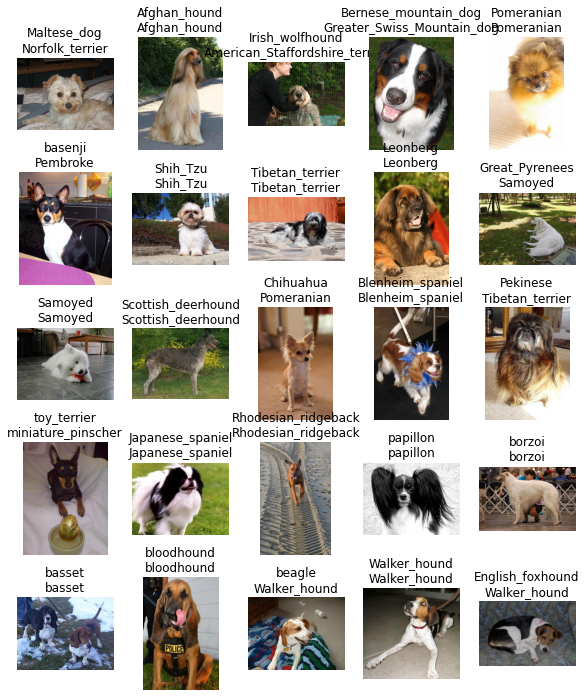

In [18]:
plt.figure(figsize=(10, 12))
i = 1
for sub_dir in os.listdir(dataset_dir):
    sub_dir_images = os.listdir(dataset_dir + sub_dir)
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 25 and j == 0:
            img_path = os.path.join(dataset_dir, sub_dir, sub_dir_image)
            img = Image.open(img_path)
            plt.subplot(5, 5, i)
            plt.axis('off')
            race = sub_dir.split('-')[1]
            prediction = classifier.predict(img_path=img_path)
            plt.title(race + '\n' + prediction.split('-')[1])
            plt.imshow(img)
            i = i + 1
            j = j + 1
plt.show()

Il donne la bonne réponse 15 fois sur 25... c'est moins bien qu'ImageNet sans le Transfer Learning, mais pas si mauvais !

CI-DESSOUS TEST DU "PLAN B" avec Keras

In [15]:
width, height = 224, 224
batch_size = 32
train_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
nb_classes = len(train_ds.class_names)
print(nb_classes, "classes")

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
120 classes


In [26]:
data_augmentation = Sequential([
  RandomFlip("horizontal", input_shape=(height, width, 3)),
  RandomRotation(factor=0.4, fill_mode="wrap"),
  RandomZoom(0.2),
  RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  RandomContrast(factor=0.2)
])

In [31]:
model.trainable = False

inputs = Input(shape=(height, width, 3))
#x = data_augmentation(inputs)
#x = model(x, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(model)
x = BatchNormalization()(x)
top_dropout_rate = 0.4
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(nb_classes, name="pred")(x)

model = Model(inputs=inputs, outputs=outputs)

radam = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
optimizer = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

TypeError: ignored

In [28]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
515/515 [==============================] - 76s 144ms/step - loss: 11.5121 - accuracy: 0.0090 - val_loss: 11.3217 - val_accuracy: 0.0075
Epoch 2/50
515/515 [==============================] - 66s 127ms/step - loss: 11.3563 - accuracy: 0.0083 - val_loss: 11.1364 - val_accuracy: 0.0087
Epoch 3/50
515/515 [==============================] - 66s 128ms/step - loss: 11.0981 - accuracy: 0.0101 - val_loss: 10.9215 - val_accuracy: 0.0080
Epoch 4/50
515/515 [==============================] - 66s 127ms/step - loss: 10.7236 - accuracy: 0.0101 - val_loss: 10.5611 - val_accuracy: 0.0083
Epoch 5/50
515/515 [==============================] - 67s 128ms/step - loss: 10.3168 - accuracy: 0.0103 - val_loss: 10.1301 - val_accuracy: 0.0085
Epoch 6/50
515/515 [==============================] - 66s 127ms/step - loss: 9.8650 - accuracy: 0.0107 - val_loss: 9.5138 - val_accuracy: 0.0092
Epoch 7/50
515/515 [==============================] - 67s 128ms/step - loss: 9.1279 - accuracy: 0.0107 - val_loss: 8.665

KeyboardInterrupt: ignored

In [ ]:
def show_perfs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Autre tentative avec exemple https://github.com/kenjitee/KenjiTee/blob/master/ViT_Tutorial.ipynb

In [8]:
import math
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

!pip install pytorch-lightning
from torchmetrics import Accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

ds=ImageFolder(dataset_dir)
indices = torch. randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

     |████████████████████████████████| 525 kB 5.1 MB/s 
     |████████████████████████████████| 132 kB 65.8 MB/s 
     |████████████████████████████████| 332 kB 48.1 MB/s 
     |████████████████████████████████| 829 kB 38.4 MB/s 
     |████████████████████████████████| 1.1 MB 44.4 MB/s 
     |████████████████████████████████| 271 kB 57.9 MB/s 
     |████████████████████████████████| 160 kB 60.5 MB/s 
     |████████████████████████████████| 192 kB 62.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=4c35b1d373eef92b2a5f4e30d169885b1eb00e73538a7749848f1188410e1eb1
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
cuda


In [9]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [10]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

In [11]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

collator = ImageClassificationCollator(feature_extractor)

train_loader = DataLoader(train_ds, batch_size=32, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collator, num_workers=2)

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()
        self.train_acc= Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        acc1 = self.train_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"train_acc", acc1, prog_bar=True)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr,weight_decay=0.0025)

In [13]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='tmp_checkpoint',
    filename='ViT-{epoch:02d}-{val_loss:.2f}',
)
trainer = pl.Trainer(callbacks=[checkpoint_callback], gpus=1, precision=16,
                     max_epochs=3)
trainer.fit(classifier, train_loader, val_loader)

Global seed set to 42
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | ViTForImageClassification | 85.9 M
1 | val_acc   | Accuracy                  | 0     
2 | train_acc | Accuracy                  | 0     
--------------------------------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
171.782   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]